In [ ]:
from IPython.display import clear_output

!pip install -q lightning tbparse

clear_output()

In [ ]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

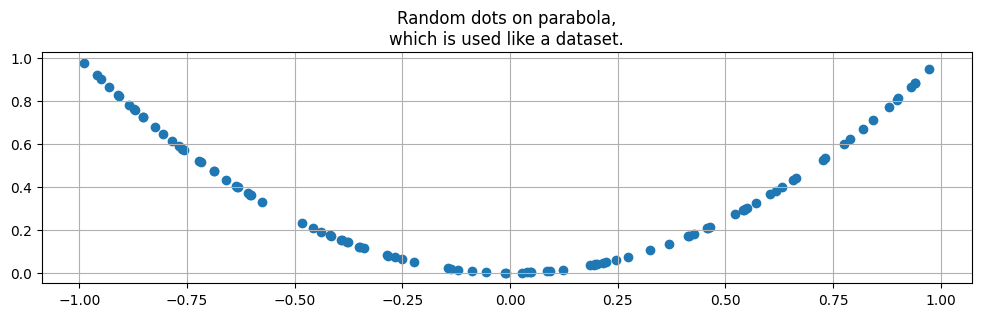

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def create_pair(num=100):
    x = np.random.uniform(low=-1, high=1, size=(num,))
    y = x * x
    return np.hstack(
        (x.reshape(-1, 1), y.reshape(-1, 1))
    )  # Create num of correct dots(x,y) on parabola


pairs = create_pair(100)
plt.figure(figsize=(12, 3))
plt.scatter(pairs[:, 0], pairs[:, 1])
plt.grid()
plt.title("Random dots on parabola,\nwhich is used like a dataset.")
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset


# Define input parameters
n_batches = 30
batch_size = 128
ls = 1  # latent space


class ParabolaDS(Dataset):
    def __init__(self, n_batches, batch_size, ls):
        # create ground true item
        self.xy_pair = torch.tensor(
            create_pair(num=(n_batches * batch_size)), dtype=torch.float
        )
        self.ls = ls

    def __len__(self):
        return self.xy_pair.shape[0]

    def __getitem__(self, idx):
        # get ground true item
        item = self.xy_pair[idx]
        # generate random noise
        noise = torch.randn(self.ls, dtype=torch.float)
        return item, noise


trainset = ParabolaDS(n_batches, batch_size, ls)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
import time
!mkdir gan_process

In [ ]:
from tbparse import SummaryReader

def tbparse_visual(log_dir, figsize=(12, 3)):
    # visualization without TensorBoard for TensorBoard logs
    clear_output()
    reader = SummaryReader(log_dir)
    df = reader.scalars

    plt.figure(figsize=figsize)
    for tag in df.tag.unique():
        if "loss" in tag:
            tag_data = df.query("`tag` == @tag").sort_values(by="step")
            plt.plot(tag_data.step, tag_data.value, label=tag)
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig(f"gan_process/loss_{time.time()}.png", bbox_inches='tight',pad_inches=0.1)
    plt.show()

In [ ]:
import pandas as pd
import seaborn as sns


def test_image(pair_gen, pairs, figsize=(12, 3)):
    # equalizing lengths for better visualization
    if len(pair_gen) > len(pairs):
        pair_gen = pair_gen[:len(pairs)]
    else:
        pairs = pairs[:len(pair_gen)]

    df = pd.DataFrame(
        data = np.concatenate([pairs, pair_gen]),
        columns=["x", "y"]
    )
    df["label"] = ["real"] * len(pairs) + ["generated"] * len(pair_gen)

    plot = sns.jointplot(data=df, x="x", y="y", hue="label")
    sns.move_legend(plot.ax_joint, "lower left")
    if figsize:
        plot.fig.set_size_inches(figsize)
    plt.axis([-1.1, 1.1, -0.1, 1.1])
    plt.grid()
    plt.savefig(f"gan_process/dots_{time.time()}.png", bbox_inches='tight',pad_inches=0)
    plt.show()

In [ ]:
from torch import nn


class Generator(nn.Module):
    def __init__(self, latent_space, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
        )  # x,y

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # real/fake
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
import lightning as L


class GAN(L.LightningModule):
    def __init__(
        self,
        generator,
        discriminator,
        lr=3e-4,
        betas=(0.9, 0.999),
        noise_in_place=False,
        latent_dim=10,
    ):
        super().__init__()
        self.automatic_optimization = False  # for hand made settings

        self.generator = generator
        self.discriminator = discriminator
        self.criterion = nn.BCELoss()
        self.real_label = 1.0
        self.fake_label = 0.0
        self.lr = lr
        self.betas = betas
        self.noise_in_place = noise_in_place
        self.latent_dim = latent_dim

    def configure_optimizers(self):
        opt_gen = torch.optim.Adam(
            self.generator.parameters(),
            lr=self.lr,
            betas=self.betas,
        )
        opt_disc = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.lr,
            betas=self.betas,
        )
        return [opt_gen, opt_disc], []

    def training_step(self, batch, batch_idx):
        if self.noise_in_place:  # for standart dataset
            self.real_items, _ = batch
            noises = torch.randn(
                (self.real_items.shape[0], self.latent_dim),
                dtype=torch.float32,
            ).to(self.device)
        else:
            self.real_items, noises = batch  # for handmade dataset
        opt_gen, opt_disc = self.optimizers()

        # ---------------------
        # Train discriminator
        # ---------------------
        self.discriminator.zero_grad()
        # 1. discriminator on real items
        real_label = torch.full(
            size=(self.real_items.shape[0], 1),
            fill_value=self.real_label,
            dtype=torch.float,
        ).to(self.device)
        disc_label = self.discriminator(self.real_items)
        loss_disc_real = self.criterion(disc_label, real_label)
        loss_disc_real.backward()

        # 2. discriminator on fake items
        fake_label = torch.full(
            size=(self.real_items.shape[0], 1),
            fill_value=self.fake_label,
            dtype=torch.float,
        ).to(self.device)
        self.fake_items = self.generator(noises)
        disc_label = self.discriminator(self.fake_items)
        loss_disc_fake = self.criterion(disc_label, fake_label)
        loss_disc_fake.backward()

        # 3. discriminator optimizer step (on real and fake items)
        opt_disc.step()
        loss_disc = 0.5 * loss_disc_real + 0.5 * loss_disc_fake
        self.log("loss/disc", loss_disc, on_epoch=False, on_step=True)

        # ---------------------
        # Train generator
        # ---------------------
        self.generator.zero_grad()
        self.fake_items = self.generator(noises)
        disc_label = self.discriminator(self.fake_items)
        loss_gen = self.criterion(disc_label, real_label)  # flip label
        loss_gen.backward()

        opt_gen.step()
        self.log("loss/gen", loss_gen, on_epoch=False, on_step=True)

        if (batch_idx + 1) % 100 == 0:
            tbparse_visual(self.logger.log_dir)
            test_image(
                self.fake_items.detach().cpu().numpy(),
                self.real_items.detach().cpu().numpy(),
            )

    def on_train_epoch_end(self):
        tbparse_visual(self.logger.log_dir)
        test_image(
            self.fake_items.detach().cpu().numpy(),
            self.real_items.detach().cpu().numpy(),
        )

In [ ]:
latent_dim = 10  # latent space
num_epochs = 1
n_batches = 10000
batch_size = 512

In [ ]:
set_random_seed(42)
trainset = ParabolaDS(n_batches, batch_size, latent_dim)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

generator = Generator(latent_space=latent_dim, hidden_dim=50)
discriminator = Discriminator(hidden_dim=50)

pl_model = GAN(generator, discriminator)

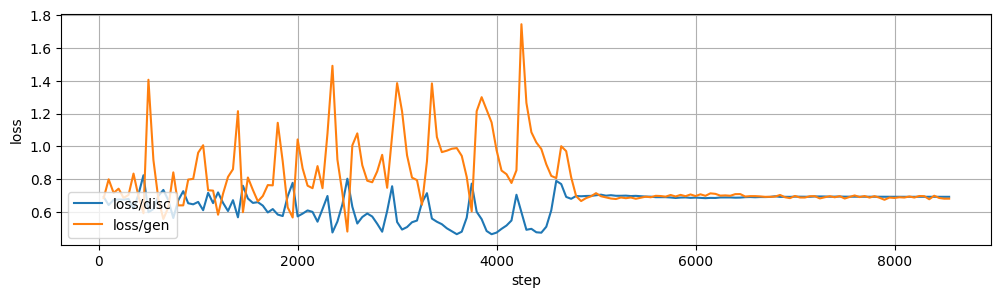

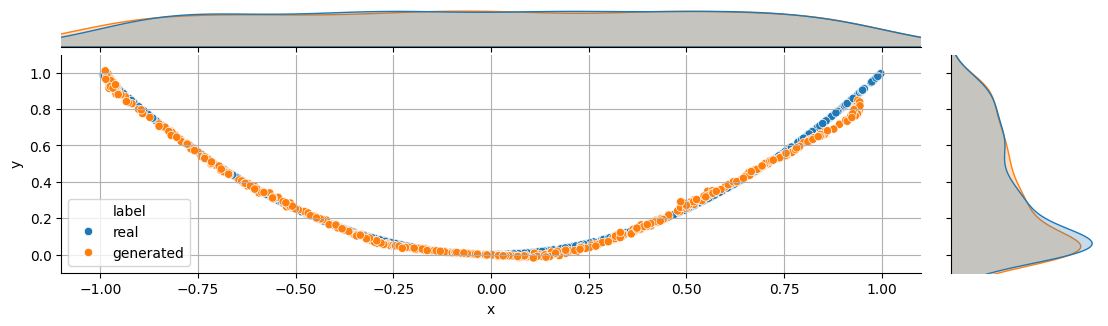

In [ ]:
pl_model = GAN(generator, discriminator)
trainer = L.Trainer(
    max_epochs=num_epochs,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./log_gan/"),
)

trainer.fit(model=pl_model, train_dataloaders=train_loader)

In [ ]:
import glob
from PIL import Image

loss = sorted(glob.glob("gan_process/loss_*.png"))
dots = sorted(glob.glob("gan_process/dots_*.png"))
pairs = list(zip(loss, dots))
len(pairs)

101

In [ ]:
loss_img = Image.open(pairs[0][0])
dots_img = Image.open(pairs[0][1])

print(loss_img.width, loss_img.height)
print(dots_img.width, dots_img.height)

1019 294
1088 306


In [ ]:
width, height = 1100, 306+294+30

for i, pair in enumerate(pairs):
    loss_img = Image.open(pair[0])
    dots_img = Image.open(pair[1])

    canvas = Image.new("RGBA", (width, height), color = (255, 255, 255))
    canvas.paste(loss_img, (10, 10))
    canvas.paste(dots_img, (10, 275+20))
    canvas.save(f"gan_process/{time.time()}_merged.png")


In [ ]:
!zip -q gan_process.zip gan_process/*_merged.png

In [ ]:
import os
import imageio.v2 as imageio

files = sorted(glob.glob("gan_process/*_merged.png"))

images = []
for file_name in files:
    images.append(imageio.imread(file_name))

imageio.mimsave("./gan_training_process.gif", images, loop=0)

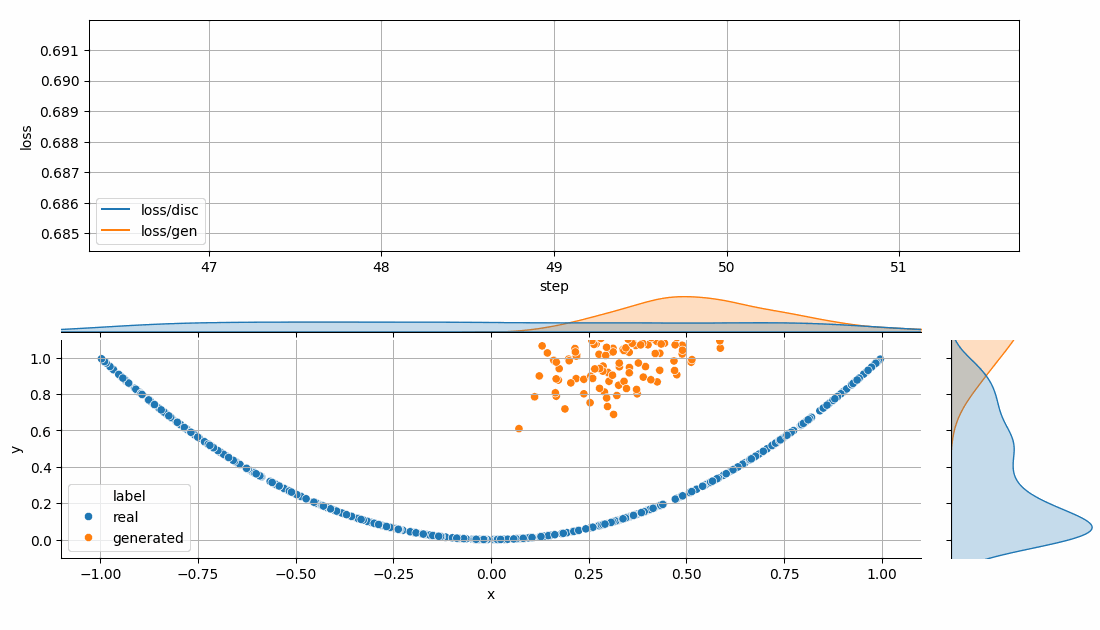

In [ ]:
from IPython.display import Image as iImage
iImage(open("./gan_training_process.gif", "rb").read())